In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline 
import seaborn as sns
import xgboost as xgb
#from xgboost import XGBRegressor, XGBRFRegressor, plot_importance, plot_tree

import warnings

warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054


In [3]:
test_df = pd.read_csv('test.csv')
test_df.head()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,19.497717,16,6,72.151322,0.388959,78.32,4,37949.724386,2,0.069692,1
1,58.173516,15,3,64.585232,0.250841,78.60,7,30194.805567,2,0.002777,10
2,33.287671,15,3,64.721969,0.336669,86.96,6,17572.925484,1,0.004316,14
3,3.287671,21,5,66.362808,0.421775,80.86,3,40209.186341,2,0.199990,17
4,10.867580,18,2,56.107566,0.313228,79.22,2,35495.525408,2,0.483696,21


In [4]:
sample_submit_df = pd.read_csv('sample_submission.csv')
sample_submit_df.head()

,Accident_ID,Severity
0,1,Minor_Damage_And_Injuries
1,10,Highly_Fatal_And_Damaging
2,14,Highly_Fatal_And_Damaging
3,17,Significant_Damage_And_Serious_Injuries
4,21,Minor_Damage_And_Injuries


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Severity                   10000 non-null object
Safety_Score               10000 non-null float64
Days_Since_Inspection      10000 non-null int64
Total_Safety_Complaints    10000 non-null int64
Control_Metric             10000 non-null float64
Turbulence_In_gforces      10000 non-null float64
Cabin_Temperature          10000 non-null float64
Accident_Type_Code         10000 non-null int64
Max_Elevation              10000 non-null float64
Violations                 10000 non-null int64
Adverse_Weather_Metric     10000 non-null float64
Accident_ID                10000 non-null int64
dtypes: float64(6), int64(5), object(1)
memory usage: 937.6+ KB


## Let me check for the null values in the data frame

In [6]:
train_df.isnull().sum()*100/train_df.shape[0]

Severity                   0.0
Safety_Score               0.0
Days_Since_Inspection      0.0
Total_Safety_Complaints    0.0
Control_Metric             0.0
Turbulence_In_gforces      0.0
Cabin_Temperature          0.0
Accident_Type_Code         0.0
Max_Elevation              0.0
Violations                 0.0
Adverse_Weather_Metric     0.0
Accident_ID                0.0
dtype: float64

### Awesome!! no null values in the data frame
## Now Some EDA

In [7]:
train_df.describe()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,41.876406,12.931100,6.564300,65.145324,0.381495,79.969331,3.814900,32001.803282,2.01220,0.255635,6266.554200
std,16.138072,3.539803,6.971982,11.882934,0.121301,2.759739,1.902577,9431.995196,1.03998,0.381128,3610.170288
min,0.000000,1.000000,0.000000,0.000000,0.134000,74.740000,1.000000,831.695553,0.00000,0.000316,2.000000
25%,30.593607,11.000000,2.000000,56.927985,0.293665,77.960000,2.000000,25757.636908,1.00000,0.012063,3139.750000
50%,41.278539,13.000000,4.000000,65.587967,0.365879,79.540000,4.000000,32060.336419,2.00000,0.074467,6280.500000
75%,52.511416,15.000000,9.000000,73.336372,0.451346,81.560000,5.000000,38380.641513,3.00000,0.354059,9391.500000
max,100.000000,23.000000,54.000000,100.000000,0.882648,97.510000,7.000000,64297.651218,5.00000,2.365378,12500.000000


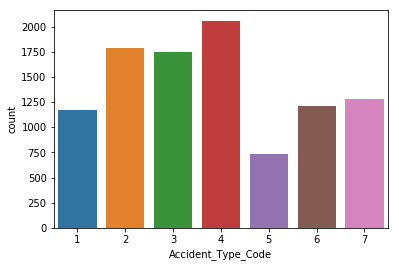

In [8]:
sns.countplot(train_df['Accident_Type_Code'])
plt.show()

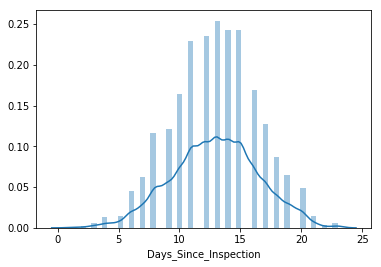

In [9]:
sns.distplot(train_df['Days_Since_Inspection'])
plt.show()

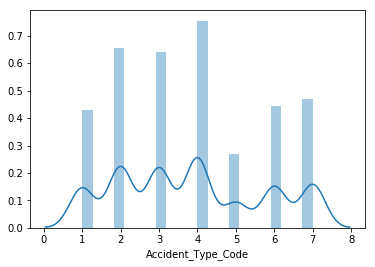

In [10]:
sns.distplot(train_df['Accident_Type_Code'])
plt.show()

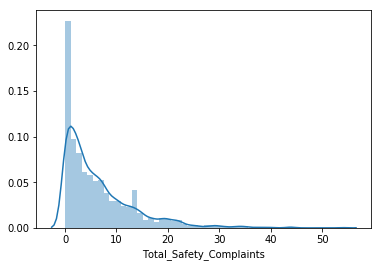

In [11]:

sns.distplot(train_df['Total_Safety_Complaints'])
plt.show()

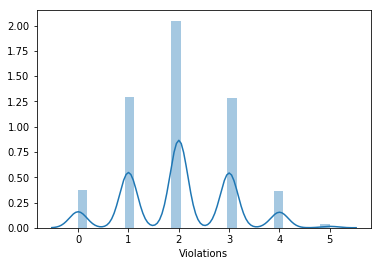

In [12]:

sns.distplot(train_df['Violations'])
plt.show()


## Let me scale the contineous variables

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
varlist = ['Safety_Score', 'Days_Since_Inspection', 
           'Total_Safety_Complaints', 'Control_Metric', 
           'Turbulence_In_gforces', 'Cabin_Temperature',
           'Max_Elevation', 'Violations',
           'Adverse_Weather_Metric'
          ]
#train_df[varlist] = scaler.fit_transform(train_df[varlist])
#test_df[varlist] = scaler.fit_transform(test_df[varlist])

train_df.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054


In [14]:
train_df.Severity.unique()



array(['Minor_Damage_And_Injuries', 'Significant_Damage_And_Fatalities',
       'Significant_Damage_And_Serious_Injuries',
       'Highly_Fatal_And_Damaging'], dtype=object)

In [15]:
#train_df.Severity = pd.Categorical(train_df.Severity)
#train_df['severity_code'] = train_df.Severity.cat.codes

In [16]:
#train_df.Severity.cat

In [17]:
def coded_outcome (row):
    code = 0
    if (row['Severity'] == 'Minor_Damage_And_Injuries') :
        code = 0
    if (row['Severity'] == 'Significant_Damage_And_Fatalities') :
        code = 1
    if (row['Severity'] == 'Significant_Damage_And_Serious_Injuries') :
        code = 2
    if (row['Severity'] == 'Highly_Fatal_And_Damaging') :
        code = 3

    return code



In [18]:
x_train_df = train_df

In [19]:
sev_map = {'Minor_Damage_And_Injuries': 0, 'Significant_Damage_And_Fatalities' : 1, 'Significant_Damage_And_Serious_Injuries':2, 'Highly_Fatal_And_Damaging':3}
#x_train_df['Severity'] = x_train_df['Severity'].applymap({'Minor_Damage_And_Injuries': 0, 'Significant_Damage_And_Fatalities' : 1, 'Significant_Damage_And_Serious_Injuries': 2, 'Highly_Fatal_And_Damaging':3})
x_train_df['Severity'] = x_train_df.apply(coded_outcome, axis = 1)
x_train_df = train_df.drop(['Accident_ID'], axis = 1)
x_test_df = test_df.drop(['Accident_ID'], axis = 1)
#x_train_df = train_df
#x_test_df = test_df
x_train_df.head()




,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric
0,0,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352
1,0,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350
2,1,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364
3,2,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728
4,1,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883


In [20]:
train_df.Severity.unique()

array([0, 1, 2, 3], dtype=int64)

In [21]:
y_train_df = x_train_df.pop ('Severity')
y_train_df.unique()

array([0, 1, 2, 3], dtype=int64)

In [22]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train_df, y_train_df, test_size=0.25, random_state=47)
eval_set = [(x_train, y_train), (x_test, y_test)]

In [23]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 4532 to 5255
Data columns (total 10 columns):
Safety_Score               7500 non-null float64
Days_Since_Inspection      7500 non-null int64
Total_Safety_Complaints    7500 non-null int64
Control_Metric             7500 non-null float64
Turbulence_In_gforces      7500 non-null float64
Cabin_Temperature          7500 non-null float64
Accident_Type_Code         7500 non-null int64
Max_Elevation              7500 non-null float64
Violations                 7500 non-null int64
Adverse_Weather_Metric     7500 non-null float64
dtypes: float64(6), int64(4)
memory usage: 644.5 KB


In [24]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [25]:
xgb_multi_clf = xgb.XGBClassifier(objective = 'multi:softmax', n_estimators=50, early_stopping_rounds=100)
#xgb_model = xgb_multi_clf.fit(x_train, y_train)

#y_train_preds = xgb_model.predict(x_train)
#y_test_preds = xgb_model.predict(x_test)
#y_test_preds_submit = xgb_model.predict(x_test_df)

#print(y_test_preds_submit)

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

k_folds = KFold(n_splits = 4, shuffle = True, random_state = 55)

params = {'learning_rate' : [.05, .1, .5],
            'min_child_weight': [1, 2, 3],
            'gamma': [.5, 1, 2],
            'subsample': [0.7, 0.85],
            'colsample_bytree': [0.8, 1.0],
            'max_depth': [4, 5, 6]
        }

gcv = GridSearchCV(xgb_multi_clf,
                  params,
                  cv = k_folds ,
                  scoring = 'accuracy',
                  n_jobs = -1,
                  verbose = 30)

gcv.fit(x_train_df, y_train_df, eval_metric=['auc', 'error'])

#y_train_preds = gcv.predict(x_train)
#y_test_preds = gcv.predict(x_test)
y_test_preds_submit = gcv.predict(x_test_df)

print(y_test_preds_submit)

Fitting 4 folds for each of 324 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   53.7s
[Paralle

[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  5.9min
[Paralle

[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed: 10.6min
[Paralle

[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 414 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 415 tasks      | elapsed: 15.7min
[Paralle

[Parallel(n_jobs=-1)]: Done 533 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 534 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 535 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 539 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 547 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed: 21.0min
[Paralle

[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 667 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 671 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 673 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 675 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 678 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 679 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed: 26.3min
[Paralle

[Parallel(n_jobs=-1)]: Done 799 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 801 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 802 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 803 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 805 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 807 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 809 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 813 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done 814 tasks      | elapsed: 31.4min
[Paralle

[Parallel(n_jobs=-1)]: Done 932 tasks      | elapsed: 35.3min
[Parallel(n_jobs=-1)]: Done 933 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 934 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 935 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done 937 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done 938 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done 939 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done 941 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done 942 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done 943 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 945 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 946 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 947 tasks      | elapsed: 35.7min
[Paralle

[Parallel(n_jobs=-1)]: Done 1064 tasks      | elapsed: 39.5min
[Parallel(n_jobs=-1)]: Done 1065 tasks      | elapsed: 39.6min
[Parallel(n_jobs=-1)]: Done 1066 tasks      | elapsed: 39.6min
[Parallel(n_jobs=-1)]: Done 1067 tasks      | elapsed: 39.6min
[Parallel(n_jobs=-1)]: Done 1068 tasks      | elapsed: 39.6min
[Parallel(n_jobs=-1)]: Done 1069 tasks      | elapsed: 39.7min
[Parallel(n_jobs=-1)]: Done 1070 tasks      | elapsed: 39.7min
[Parallel(n_jobs=-1)]: Done 1071 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done 1073 tasks      | elapsed: 39.9min
[Parallel(n_jobs=-1)]: Done 1074 tasks      | elapsed: 39.9min
[Parallel(n_jobs=-1)]: Done 1075 tasks      | elapsed: 39.9min
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed: 39.9min
[Parallel(n_jobs=-1)]: Done 1077 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-1)]: Done 1078 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-1)]: Done 1079 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1195 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 1196 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 1197 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 1198 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 1199 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 1201 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 1203 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 1204 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 1205 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 1206 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 1207 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-1)]: Done 1209 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed: 

[3 1 2 ... 2 2 3]


In [27]:
def outcome_reversemap (row):
    code = 0
    if (row['Severity'] == 0) :
        code = 'Minor_Damage_And_Injuries'
    if (row['Severity'] == 1) :
        code = 'Significant_Damage_And_Fatalities'
    if (row['Severity'] == 2) :
        code = 'Significant_Damage_And_Serious_Injuries'
    if (row['Severity'] == 3) :
        code = 'Highly_Fatal_And_Damaging'

    return code


In [28]:
test_df['Severity'] = y_test_preds_submit
test_df['Severity'] = test_df.apply(outcome_reversemap, axis = 1)

In [29]:
test_df.head()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID,Severity
0,19.497717,16,6,72.151322,0.388959,78.32,4,37949.724386,2,0.069692,1,Highly_Fatal_And_Damaging
1,58.173516,15,3,64.585232,0.250841,78.60,7,30194.805567,2,0.002777,10,Significant_Damage_And_Fatalities
2,33.287671,15,3,64.721969,0.336669,86.96,6,17572.925484,1,0.004316,14,Significant_Damage_And_Serious_Injuries
3,3.287671,21,5,66.362808,0.421775,80.86,3,40209.186341,2,0.199990,17,Highly_Fatal_And_Damaging
4,10.867580,18,2,56.107566,0.313228,79.22,2,35495.525408,2,0.483696,21,Significant_Damage_And_Fatalities


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print("Training F1 Micro Average: ", f1_score(x_train, y_train_preds, average = "micro"))
print("Test F1 Micro Average: ", f1_score(x_test, y_test_preds, average = "micro"))
print("Test Accuracy: ", accuracy_score(x_test, y_test_preds))

In [30]:
test_df[['Accident_ID', 'Severity']]

,Accident_ID,Severity
0,1,Highly_Fatal_And_Damaging
1,10,Significant_Damage_And_Fatalities
2,14,Significant_Damage_And_Serious_Injuries
3,17,Highly_Fatal_And_Damaging
4,21,Significant_Damage_And_Fatalities
5,40,Significant_Damage_And_Fatalities
6,45,Significant_Damage_And_Fatalities
7,50,Highly_Fatal_And_Damaging
8,52,Highly_Fatal_And_Damaging
9,85,Significant_Damage_And_Serious_Injuries


In [31]:
test_df[['Accident_ID', 'Severity']].to_csv('predictions.csv', index=False)

In [32]:
gcv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, early_stopping_rounds=100,
       gamma=0.5, learning_rate=0.5, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.85, verbosity=1)

from sklearn.svm import SVC 
# creating a KFold object with 4 splits 
k_folds_svc = KFold(n_splits = 4, shuffle = True, random_state = 65)

hyper_params = [ {'gamma': [1, .1,.01, .001],
                     'C': [.1, 1, 10, 100]}]

svm_model = SVC(kernel="linear")
#svm_model = SVC(kernel="sigmoid")

model_cv_svc = GridSearchCV(estimator = svm_model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        n_jobs = -1,
                        cv = k_folds_svc, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv_svc.fit(x_train, y_train)                  

print(model_cv_svc.best_params_) 

print(model_cv_svc.best_estimator_) 

#y_train_preds_svc = model_cv_svc.predict(x_train)
#y_test_preds_svc = model_cv_svc.predict(x_test)
y_test_preds_submit_svc = model_cv_svc.predict(x_test_df)

print(y_test_preds_submit_svc)


test_df['Severity'] = y_test_preds_submit_svc
test_df['Severity'] = test_df.apply(outcome_reversemap, axis = 1)
test_df[['Accident_ID', 'Severity']].to_csv('predictions_svc.csv', index=False)
